# TREPAN breakdown

https://proceedings.neurips.cc/paper_files/paper/1995/file/45f31d16b1058d586fc3be7207b58053-Paper.pdf

The interpretation is done by
Roberto Confalonieri & Anders Imenes
2023

![TREPAN Algorithm](trepan.png)


## Main task
The task of the algorithm is: Given a trained neural network and the data on which is was trained, produce a decision tree that is comprehensible, yet classifies instances the same way as the network.

Terms:
- node = either a leaf node with a target label as value, or an internal node with a split condition.
- fidelity(n) = a ratio in which the decision trees makes the same predictions as the neural network at node n.
- reach(n) = the fraction of original training examples that reach Node n.
- best_node = f(n) = reach(n) * (1 - fidelity(n))
- candidate splits: All possible splits in a training set X.
- best binary split: The split with the gain (criterion: gain ratio, impurity: entropy)
- m-of-n split: A split with several conditions, where n is the number of conditions, and m is the threshold (an integer) of conditions that need to be satisfied. In a 2-of-{A, B, C} split, where ABC are conditions, then AB, AC and BC would satisfy the split.
- An "internal node" is opposite to leaf nodes, and will have as many children as there are outcomes of the m-of-n split.
- A internal node becomes a leaf node if a stopping criteria is met - either the proportion of the most common target label is above some cut-off value (default 0.8) or some predefined maximum number of nodes. If the latter, then the target label with the highest gain ratio will be the value of the leaf.
- impurity measure: entropy.
- criterion: Gain ratio. That is, information gain / intrinsic value.

### Preparations
1. Train a neural network. We use PyTorch. Create a class for a simple network, and have a predict method inside this class.

2. Create an oracle class. The self.model will be the previously trained neural network instance. The oracle class has two methods. One is a distribution method that models the input data X. This method is runned before we start the trepan algorithm. If feature is discrete, use a frequency count to model. If continuous, use Kernel density estimation. The other method is called generate instances, and it uses the previous distrubution results and a set of inputted constraints on the generation of x amount of new instances that can we used in our neural network for new predictions.

### The Main pipeline; the way I will implement it:


#### Fit function
0. Input training examples (X_true, y_true) and features (other copy of X_true).
1. Identify all possible candidate splits for all features within input features, call this set F.
2. We define an empty queue.
3. We predict the y_predicted labels using our oracle predict method with training_examples.
4. We initiate a root node as a leaf node, T, with no constraints initially.
5. We create a tuple (T: Node, training_data: pd.DataFrame, constraints: dict)
6. push it the queue.
7. Run _best_first_tree_expansion 

#### _best_first_tree_expansion method
Run as long as 


Repeat

1. Pop N from the queue.
    - Current constraints_N
    - Current training examples_N
2. Define a subset F_N, where F_N ⊆ F and F_N satisfy constraints_N.
3. Create a list of instances X_N, where X_N element of (training_Examples_n and oracle.generate_instances(constraints). Summation should be fixed, that is, generation gets larger as original data gets smaller). We need to keep a separation of original training_examples instances and generated instances.
4. Use X_N to calculate the highest gain ratio criterion split in F_N. Call this best_binary_split.
5. Define best_binary_split as a 1-of-1 (MofN class) split, that is 1-of-{best_binary_split_condition}.
6. If the best binary split already has a gain ratio of 1.0 (maximum), then save this split as 'best_split' (on 1-of-{best_binary_split_condition} format) and skip to step 10.
7. Use 1-of-1 as starting point. Use operators m-of-(n+1) and (m+1)-of-(n+1) to traverse search. n is typically smaller than d, where d is the dimension of the input space. But it can be larger. max-condition is parameter in algorithm. There CAN be several conditions from the same feature in a single m-of-n split.* Note that the growth becomes huge very quickly. For instance, 4-of-8 yields 70 possible logical outcomes (which correspons to number of childnodes). Max_child is a parameter which does not evaluate any m-of-n structure if is has more than max_child logical outcomes.
8. For every new inclusion of n, that is when a operator is used, n+1, try for all inclusion candidate splits in F_N.(There might be a way here to determine if we can tell beforehand what candidates cannot improve the case, to make the algorithm run more efficient). For every iteration, if it beats the current mest gain ratio, save the split and the gain ratio and the threshold.
9. After iterating through all structures and all candidates in that structure, we are left with a m-of-n best split, where m is a threshold number, and n is a set of n conditions in F_N. Save this to 'best_split'
10. We change N to an internal node with best split.

11. For every logical outcome of our m-of-n condition (AB, AC, BC in the case of 2ofABC), create a new child node (leaf node) C, where C.parent = N.
12. Define constraints_c as constraints of N and the constraints of the current outcome, for instance AB.
13. Generate a new set of instances with the oracle to the same fixed size, based on the new constraints. Predict these instances in the network to obtain target labels. 
14. With these instances, calculate the proportion of the most common target label. If this is higher than some cut-off parameter, remain a leaf node with this class as value.
15. If below, define examples_C as the subset of examples_N that satisfy the constraints. 
16. Push (C, examples_C, constraints_c) into queue. 

Until

- the number_of_nodes in the tree is less than the parameter tree_size_limit.
- There are still nodes in the queue.

After a single iteration of the while loop, we calculate all the node scores for the nodes in the queue, using the node evaluation formula. Then, we select the next node we process as the one with the highest score.

### Node evaluation
The algorithm expands in a best-first approach. That means, after an arbitrary iteration in our expansion phase, we will evaluate each of the entries in our Queue, and select the one node with highest f(n) score, where

f(n) = reach(n) * (1 - fidelity(n)),

where reach is the number of original training examples reaching that specific node, and fidelity is ratio of which the predictions from the oracle is agreeing with the decision tree.

### The Oracle
The oracle has a neural network and a method to generate random instances based on constraints.

It is used in three different areas of the algorithm.
1. To initially predict y_predicted on the training examples. This must be done in order to actually extract the logic from the neural network. If we dont do this, then, we use y_true. In this case, we wouldnt calculate the fidelity towards the model, but towards the original dataset, which essentially would be to just build a decision tree without an oracle.
2. Inside the expansion, It is used to generate more instances for evaluation of the candidate splits F_N, and also predicting their labels with the neural netowork, self.model in Oracle class.
3. After the best split is found, the oracle is used to generate more instances with the current predictions and predict them. If the proportion of the most common target class predictions is bigger than some cut off (default 0.8) we keep this node as a leaf node with value as target class.

The oracle intitally analyses the data in order to make a distribution of it. Based on this distribution, it generates instances of data randomly given this distribution and constraints in another method.

Two methods for generating instances:
Done once: distribution identification
This method find the distribution of the data from training_examples.
If data is discrete, it is a frequency count.
If data is continuous, is a Kernel distribution estimation model.

### Stopping criterias
- If it reaches a maximum number of internal nodes
- No more internal nodes in queue. A internal node becomes a leaf node when the proportion of predicted labels, p_c,  are above some cut off parameter, AND we have generated enough instances to satisfy a confidence interval for this prediction. prob(p_c < 1 - epselon) < gamma, where epselon and gamma are parameters of the algorithm



Uncertainties:

- Can you have several thresholds from the same feature in a m-of-n split? Yes. See the plot underneath as an illustration. In this case, we get the best gain ratio by setting two lines on the same axis (that is, same feature), and not one line on the x axis and one on the right. In this case a 2-of-2 would return best gain: 2-of-{'feature 1' <= 1, 'feature 1' >= -1}

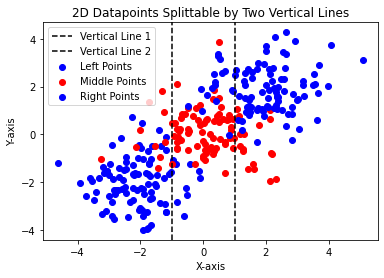

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data points
n_points = 100
left_points = np.random.normal(loc=-2, scale=1, size=(n_points, 2))
middle_points = np.random.normal(loc=0, scale=1, size=(n_points, 2))
right_points = np.random.normal(loc=2, scale=1, size=(n_points, 2))

# Plot data points
plt.scatter(left_points[:, 0], left_points[:, 1], c='blue', label='Left Points')
plt.scatter(middle_points[:, 0], middle_points[:, 1], c='red', label='Middle Points')
plt.scatter(right_points[:, 0], right_points[:, 1], c='blue', label='Right Points')

# Plot vertical lines
plt.axvline(x=-1, linestyle='--', color='black', label='Vertical Line 1')
plt.axvline(x=1, linestyle='--', color='black', label='Vertical Line 2')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Datapoints Splittable by Two Vertical Lines')
plt.legend()
plt.show()
